In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import random
import string

In [2]:
def get_data():
    p = 0.02  
    names = [i for i in range(785)]
    dataset = pd.read_csv('A_Z Handwritten Data.csv', names=names,skiprows=lambda i: i>0 and random.random() > p)
    X = dataset.loc[:,1:]
    X = X/255
    Y = dataset.loc[:,0]
    enc = OneHotEncoder()
    Y = enc.fit_transform(np.array(Y).reshape(-1,1))
    #print(Y.toarray().shape)
    #print(type(Y.toarray()))
    #images = np.multiply(images, 1.0 / 255.0)
    # split the data into training (80%) and testing (20%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.20)
    return X_train.values, X_test.values, Y_train.toarray(), Y_test.toarray()

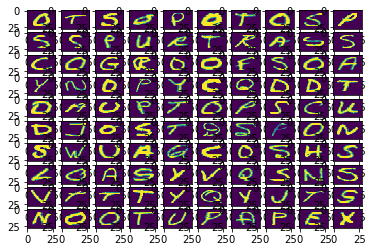

In [3]:
def visualize_data():
    X_train, X_test ,Y_train, Y_test  = get_data()
    # visualize data by plotting images 
    fig,ax = plt.subplots(10,10) 
    k = 0
    for i in range(10): 
        for j in range(10): 
            ax[i][j].imshow(X_train[k].reshape(28,28), aspect='auto') 
            k += 1
    plt.show() 
    
visualize_data()

In [4]:
def predictor():
    X_train, X_test ,Y_train, Y_test  = get_data()
    N = X_train.shape[1]
    #Defining number of neuron units in each layer
    neurons1 = 512
    neurons2 = 256
    neurons3 = 128
    outputl = 26

    #Session creation
    session = tf.InteractiveSession()

    #Placeholders for inputs
    X = tf.placeholder(dtype = tf.float32, shape =[None,N])
    Y = tf.placeholder(dtype = tf.float32, shape = [None,26])

    #Initialisers for weights and biases
    sigma = 1
    weights_in_1 = tf.random_normal_initializer(stddev=(2.0/N)**0.5)
    weights_in_2 = tf.random_normal_initializer(stddev=(2.0/neurons1)**0.5)
    weights_in_3 = tf.random_normal_initializer(stddev=(2.0/neurons2)**0.5)
    weights_in_4 = tf.random_normal_initializer(stddev=(2.0/neurons3)**0.5)
    biases_in = tf.zeros_initializer()

    #hidden weights
    w_1 = tf.get_variable("w_1", shape=(N,neurons1), initializer=weights_in_1)
    b_1 = tf.get_variable("b_1", shape=(neurons1), initializer=biases_in)
    w_2 = tf.get_variable("w_2",shape=(neurons1,neurons2),initializer=weights_in_2,)
    b_2 = tf.get_variable("b_2",shape=(neurons2),initializer=biases_in,)
    w_3 = tf.get_variable("w_3",shape=(neurons2,neurons3),initializer=weights_in_3,)
    b_3 = tf.get_variable("b_3",shape=(neurons3),initializer=biases_in,)

    #Output weights
    out_w = tf.get_variable("out_w",shape=(neurons3,outputl),initializer=weights_in_4,)
    out_b = tf.get_variable("out_b",shape=(outputl),initializer=biases_in,)


    #Saver to save weights
    saver = tf.train.Saver()


        #256*784  784*512  = 256*512
        #256*512  512*256  = 256*256
        #256*256  256*128  = 256*128
        #256*128  128*26 = 256*26

    #Defining hidden layers
    hidden_1 = tf.nn.relu(tf.add(tf.matmul(X,w_1),b_1))
    hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1,w_2),b_2))
    hidden_3 = tf.add(tf.matmul(hidden_2,w_3),b_3)

    #Output layer
    output = tf.nn.relu(tf.add(tf.matmul(hidden_3,out_w),out_b))

    #Cost function
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = output, labels = Y))
    #Optimizer(Stochastic gradient extension)

    optimizer = tf.train.AdamOptimizer().minimize(cost)

    #Calling Initialisers
    session.run(tf.global_variables_initializer())
    #new_saver = tf.train.import_meta_graph('my_test_model-1000.meta')
    #new_saver.restore(sess, tf.train.latest_checkpoint('./'))

    #fit neural sessionwork
    batch_size = 262
    loss_train = []
    loss_test = []

    epoches = 15
    for e in range(0,epoches):

        #shuffle training data
        shuffle_indices = np.random.permutation(np.arange(len(Y_train)))
        X_train = X_train[shuffle_indices]
        Y_train = Y_train[shuffle_indices]

        #minibatch training
        for i in range(0,len(Y_train)//batch_size):
            start = i*batch_size
            batch_x = X_train[start:start+batch_size]
            batch_y = Y_train[start:start+batch_size]
            
            #run optimizer
            session.run(optimizer,feed_dict={X:batch_x,Y:batch_y})            
            #show progress
        loss_train.append(session.run(cost,feed_dict={X:X_train,Y:Y_train}))
        loss_test.append(session.run(cost,feed_dict={X:X_test,Y:Y_test}))
        print('Loss Train iter{}: {}'.format(e, loss_train[-1]))
        print('Loss Test iter{} : {}'.format(e, loss_test[-1]))
        
        saver.save(session,'model_data/',global_step =0)


    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output), 1), tf.argmax(Y,1))
    # Operation calculating the accuracy of our predictions
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("\nTest Accuracy: {}".format(session.run(accuracy,feed_dict={X:X_test,Y:Y_test})))
    
    #prediction
    t = list(string.ascii_uppercase)
    p = tf.argmax(tf.nn.softmax(output),1)
    print("\nprediction: ",t[int(session.run(p,feed_dict={X:X_test[0].reshape(1,-1)}))])
    print("\ntrue image")
    plt.imshow(X_test[0].reshape(28,28))
    plt.show()
    writer = tf.summary.FileWriter('./my_graph',session.graph)
    writer.close()
    session.close()


Loss Train iter0: 1.2295513153076172
Loss Test iter0 : 1.2973062992095947
Loss Train iter1: 0.9436917901039124
Loss Test iter1 : 1.075706958770752
Loss Train iter2: 0.7028084993362427
Loss Test iter2 : 0.8326115012168884
Loss Train iter3: 0.5928376913070679
Loss Test iter3 : 0.7441882491111755
Loss Train iter4: 0.5264074802398682
Loss Test iter4 : 0.7077001333236694
Loss Train iter5: 0.47361433506011963
Loss Test iter5 : 0.6834337711334229
Loss Train iter6: 0.4486130177974701
Loss Test iter6 : 0.664523184299469
Loss Train iter7: 0.42677971720695496
Loss Test iter7 : 0.6790149211883545
Loss Train iter8: 0.40296652913093567
Loss Test iter8 : 0.6440699696540833
Loss Train iter9: 0.3853737711906433
Loss Test iter9 : 0.6549862623214722
Loss Train iter10: 0.37625232338905334
Loss Test iter10 : 0.6383792757987976
Loss Train iter11: 0.3715982139110565
Loss Test iter11 : 0.6397504210472107
Loss Train iter12: 0.36455920338630676
Loss Test iter12 : 0.6393917202949524
Loss Train iter13: 0.36134004

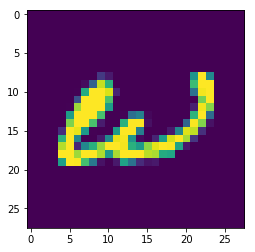

In [5]:
predictor()